In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

import torch
torch.set_default_dtype(torch.float64)

In [2]:
os.chdir(cwd + '/pilot')
responses = np.load('responses.npy')

mask_all = torch.from_numpy((~np.isnan(responses)).astype(np.uint8))
responses_all = torch.from_numpy(np.nan_to_num(responses).astype(np.long))

offers_all = torch.from_numpy(np.load('offers.npy')).long()
outcomes = torch.from_numpy(np.load('outcomes.npy')).double()
outcomes[outcomes < 2] = (outcomes[outcomes < 2] + 1)/2
outcomes[torch.isnan(outcomes)] = 0.
outcomes_all = outcomes.long()

In [3]:
# exclude non-explorers

non_expl = torch.sum(torch.squeeze(responses_all == 2), 0) < 20

mask_expl = mask_all[..., ~non_expl]
responses_expl = responses_all[..., ~non_expl]
offers_expl = offers_all[..., ~non_expl]
outcomes_expl = outcomes_all[..., ~non_expl]

mask_c1 = mask_all[..., :15][..., ~non_expl[:15]]
mask_c2 = mask_all[..., 15:][..., ~non_expl[15:]]

responses_c1 = responses_all[..., :15][..., ~non_expl[:15]]
responses_c2 = responses_all[..., 15:][..., ~non_expl[15:]]

offers_c1 = offers_all[..., :15][..., ~non_expl[:15]]
offers_c2 = offers_all[..., 15:][..., ~non_expl[15:]]

outcomes_c1 = outcomes_all[..., :15][..., ~non_expl[:15]]
outcomes_c2 = outcomes_all[..., 15:][..., ~non_expl[15:]]

In [4]:
from befit.agents import RLTempRevLearn
from befit.inference import DirichletProcessPrior, Horseshoe

In [16]:
trials = 200

rl_agent = RLTempRevLearn(runs=responses_expl.shape[-1], trials=trials)
rl_agent.set_parameters()

ps_rl = []
me_rl = []
for i in range(11,12):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_expl[:, T1:T2]
    offers = offers_expl[:, T1:T2]
    outcomes = outcomes_expl[:, T1:T2]
    responses = responses_expl[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = DirichletProcessPrior(rl_agent, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl.append(rl_infer.get_log_evidence_per_subject(num_particles=200))

Mean ELBO 1187.88: 100%|██████████| 200/200 [27:31<00:00,  8.16s/it]


(array([509.,   0., 471.,   0.,   0.,  12.,   0.,   5.,   0.,   3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

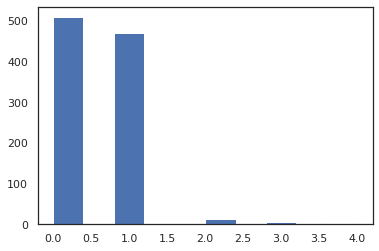

In [27]:
plt.hist(ps_rl[0][-1][:,13])

In [ ]:
# performe sequential parameter estimate and model selection
trials = 200

rl_agent_c1 = RLTempRevLearn(runs=responses_c1.shape[-1], trials=trials)
rl_agent_c1.set_parameters()

rl_agent_c2 = RLTempRevLearn(runs=responses_c2.shape[-1], trials=trials)
rl_agent_c2.set_parameters()

ps_rl_c1 = []
me_rl_c1 = []
ps_rl_c2 = []
me_rl_c2 = []
for i in range(1):
    T1 = 50*i
    T2 = T1 + trials
    mask = mask_c1[:, T1:T2]
    offers = offers_c1[:, T1:T2]
    outcomes = outcomes_c1[:, T1:T2]
    responses = responses_c1[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = Horseshoe(rl_agent_c1, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c1.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c1.append(rl_infer.get_log_evidence_per_subject(num_particles=200))
    
    mask = mask_c2[:, T1:T2]
    offers = offers_c2[:, T1:T2]
    outcomes = outcomes_c2[:, T1:T2]
    responses = responses_c2[:, T1:T2]
    stimulus = {'offers': offers, 
                'outcomes': outcomes,
                'mask': mask.double()}
    
    mask[:, :50] = 0
    rl_infer = Horseshoe(rl_agent_c2, stimulus, responses, mask=mask)
    rl_infer.infer_posterior(iter_steps=200)
    
    labels = ['alpha', 'kappa', 'beta', 'theta']
    ps_rl_c2.append(rl_infer.sample_posterior(labels, n_samples=1000))
    
    me_rl_c2.append(rl_infer.get_log_evidence_per_subject(num_particles=200))

In [16]:
me_rl_c1
'[-145.8267,  -89.7420, -112.8995, -121.8902, -121.2229,  -82.7167, -118.3858]'

[tensor([-135.1732,  -72.3869, -101.5068,  -99.1438, -109.3649,  -58.7079,
          -85.7989])]